
INTEGRATED POSE CLUSTERING & CLINICAL ANALYSIS PIPELINE

[1/4] Loading and preprocessing data...
Loaded 42853 rows, 57 columns
Participants found: ['Therapist', 'Child']

[2/4] Analyzing clinical interactions...


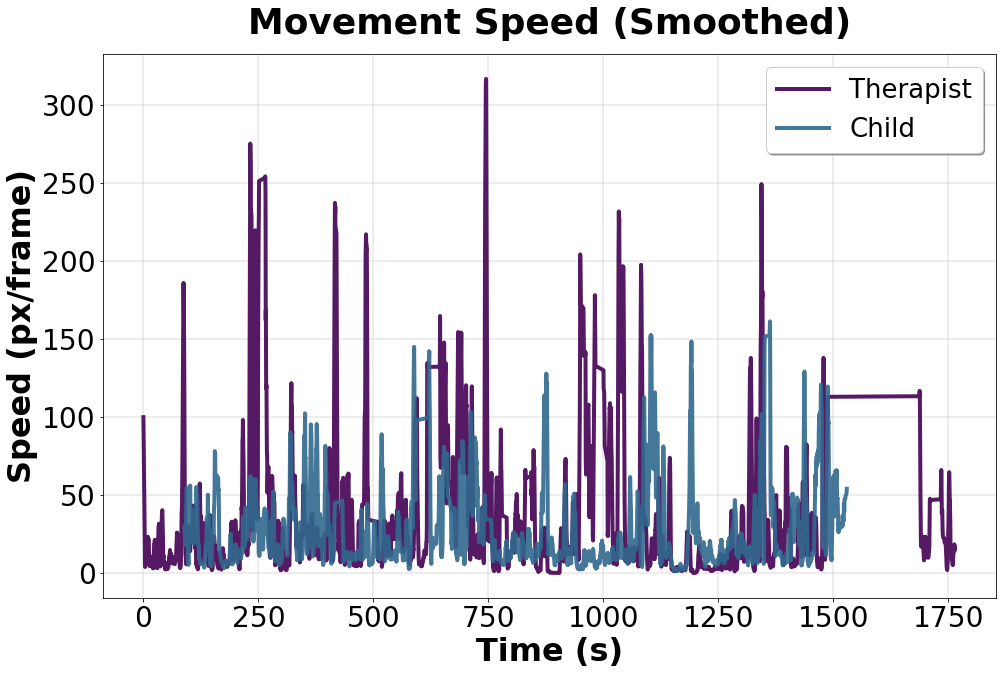

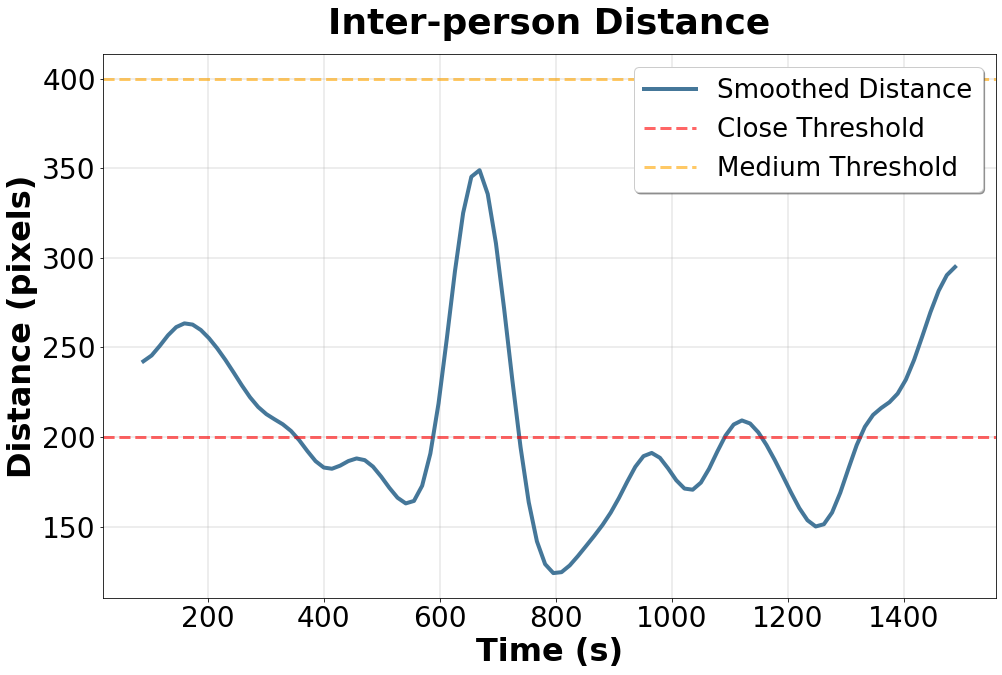

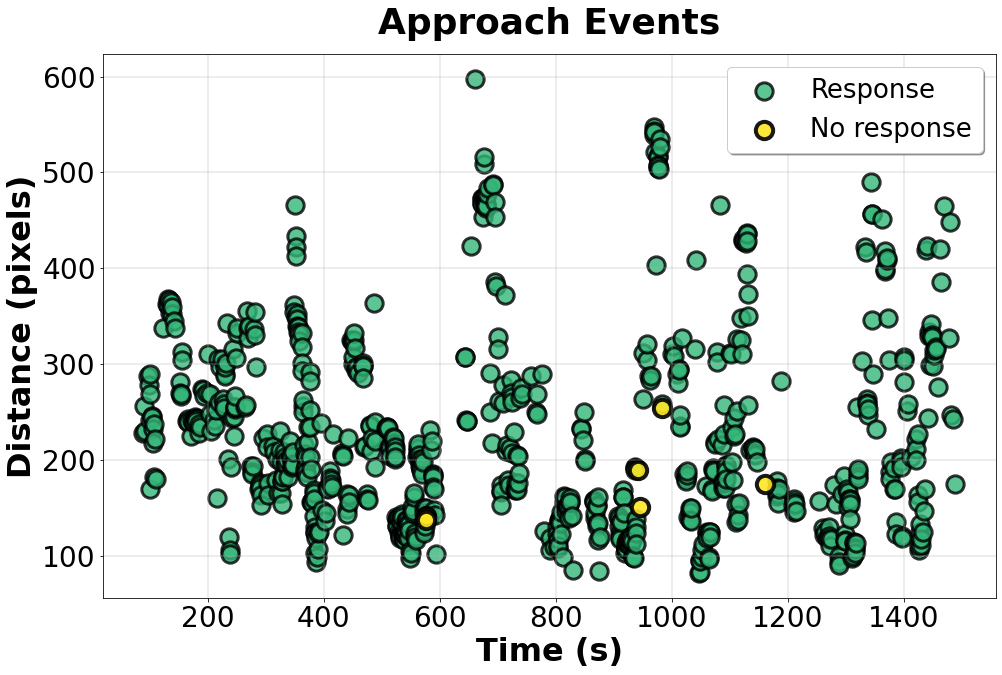

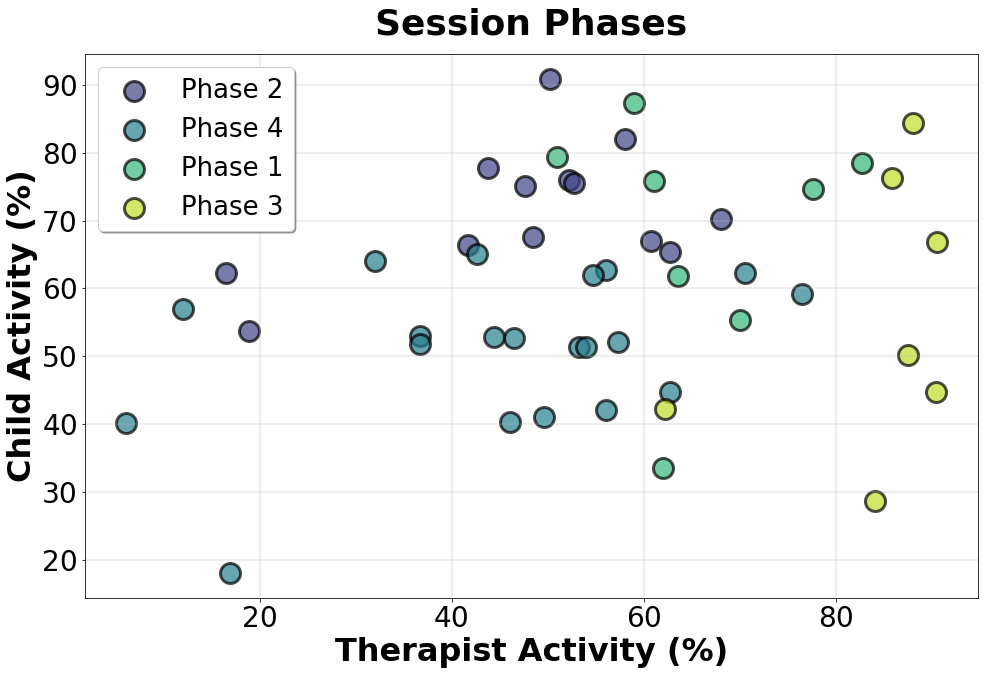


[3/4] Clustering pose patterns...
  Found persons: Child, Therapist
  → Analyzing Child...


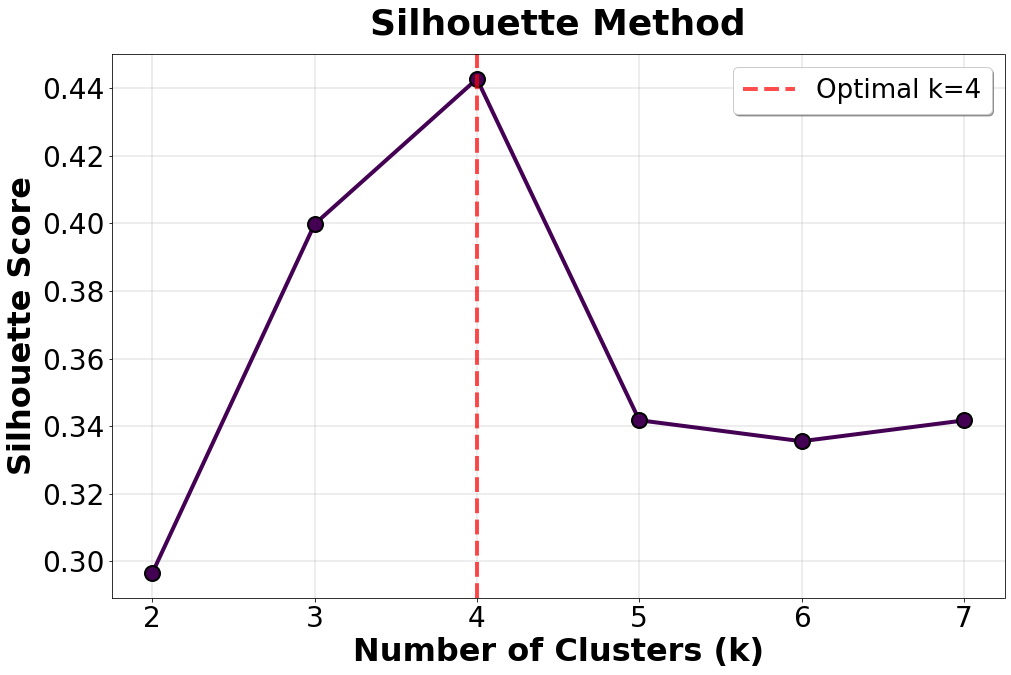

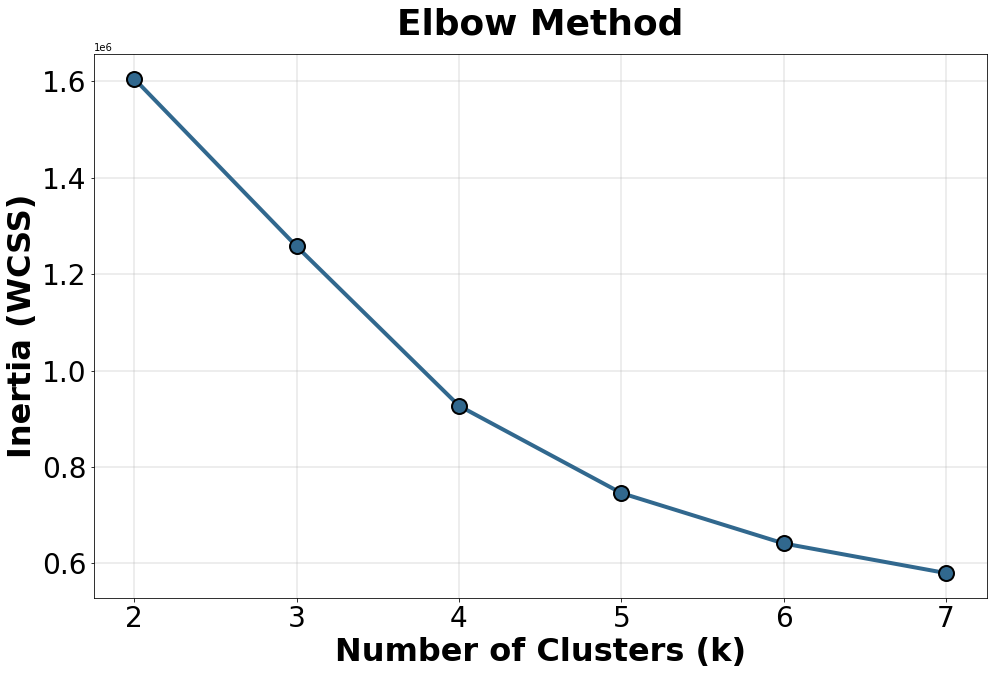

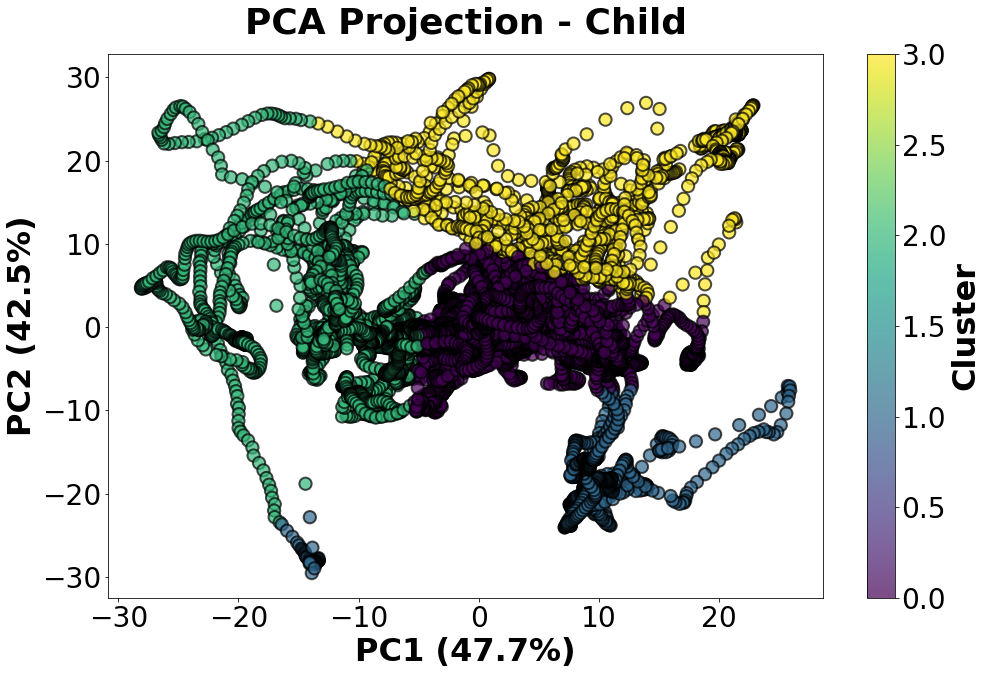

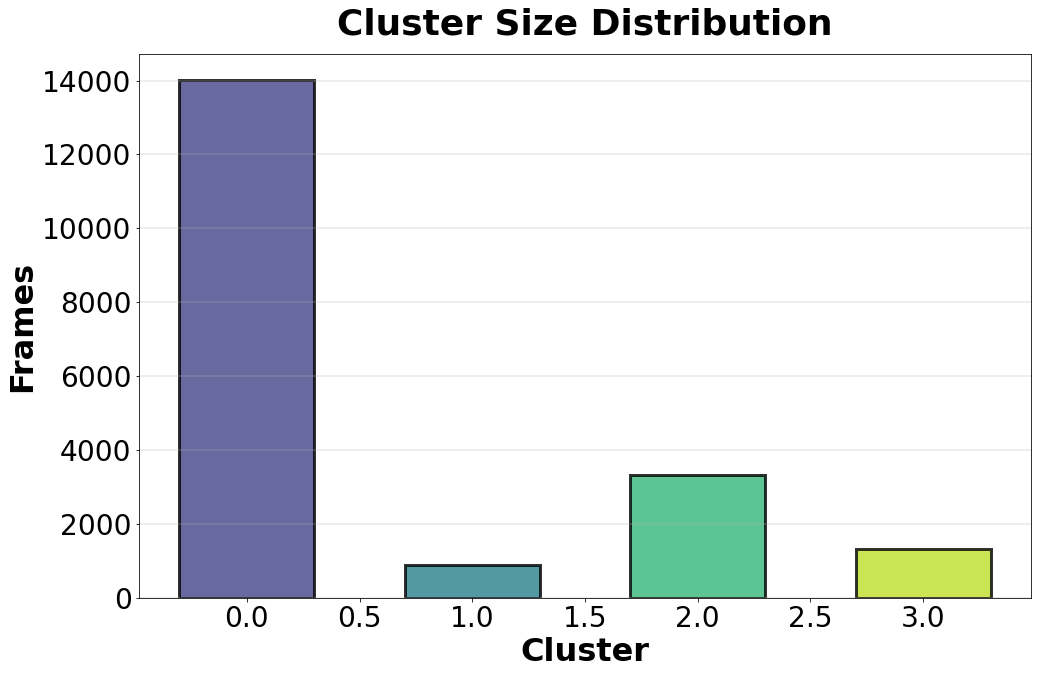

  → Analyzing Therapist...


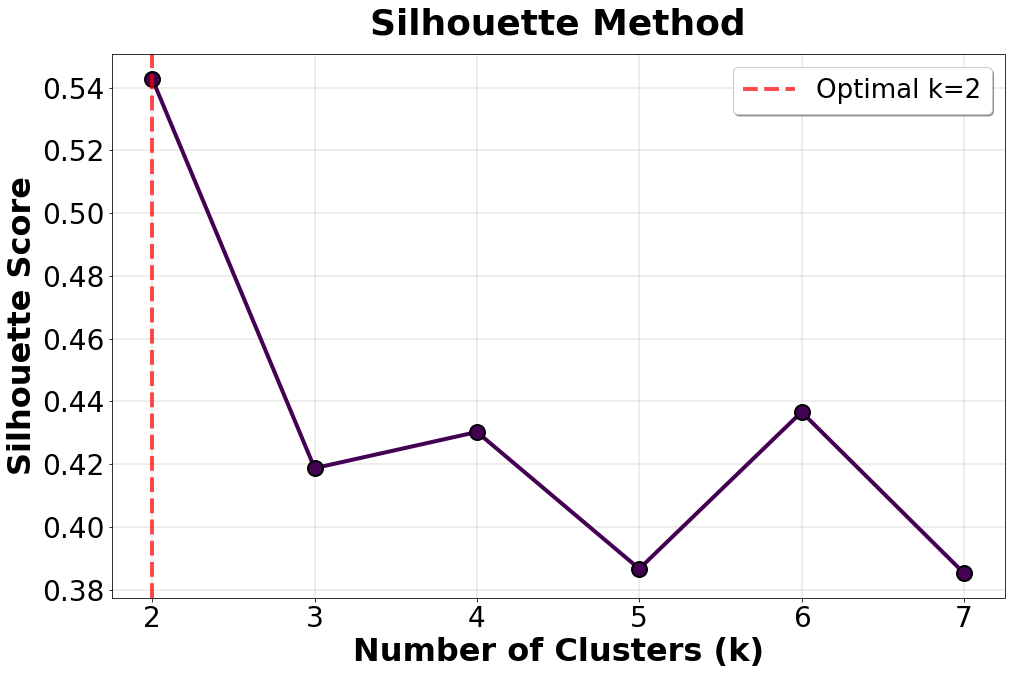

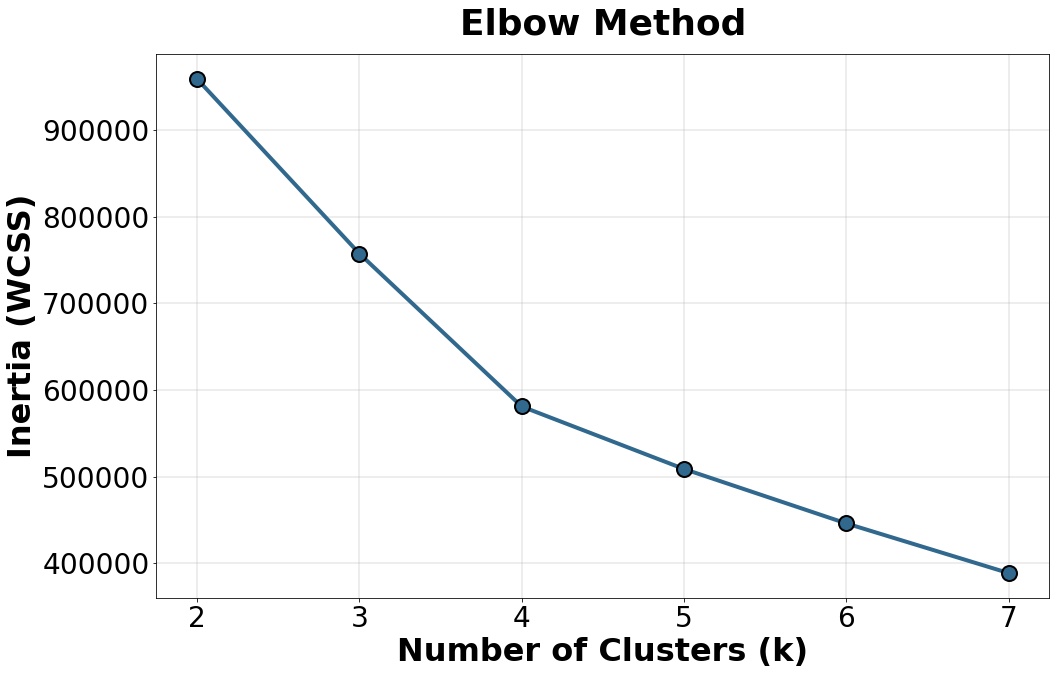

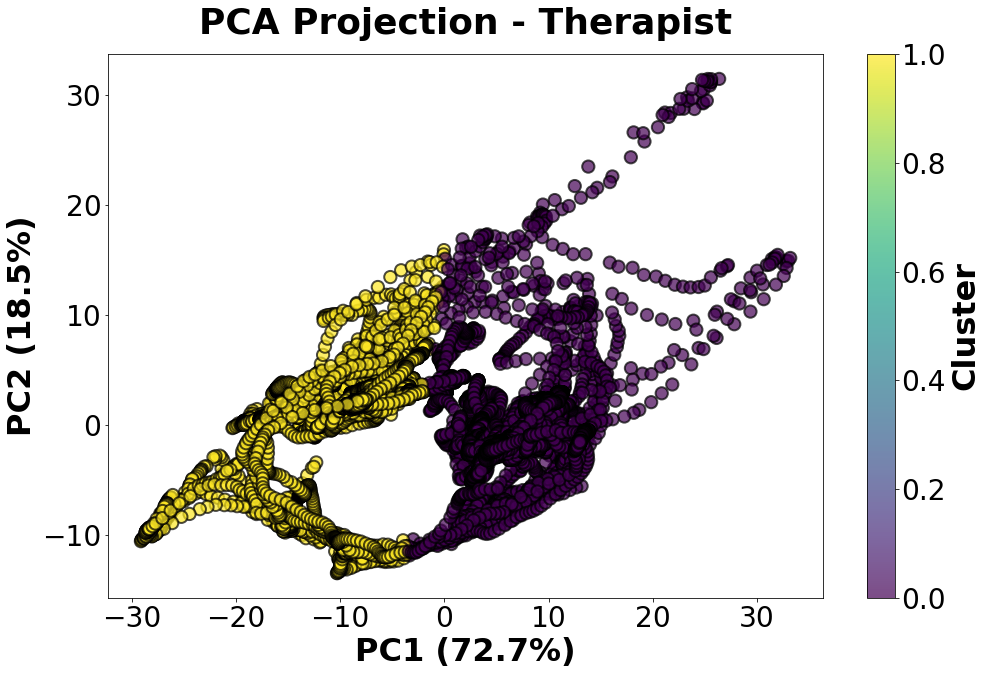

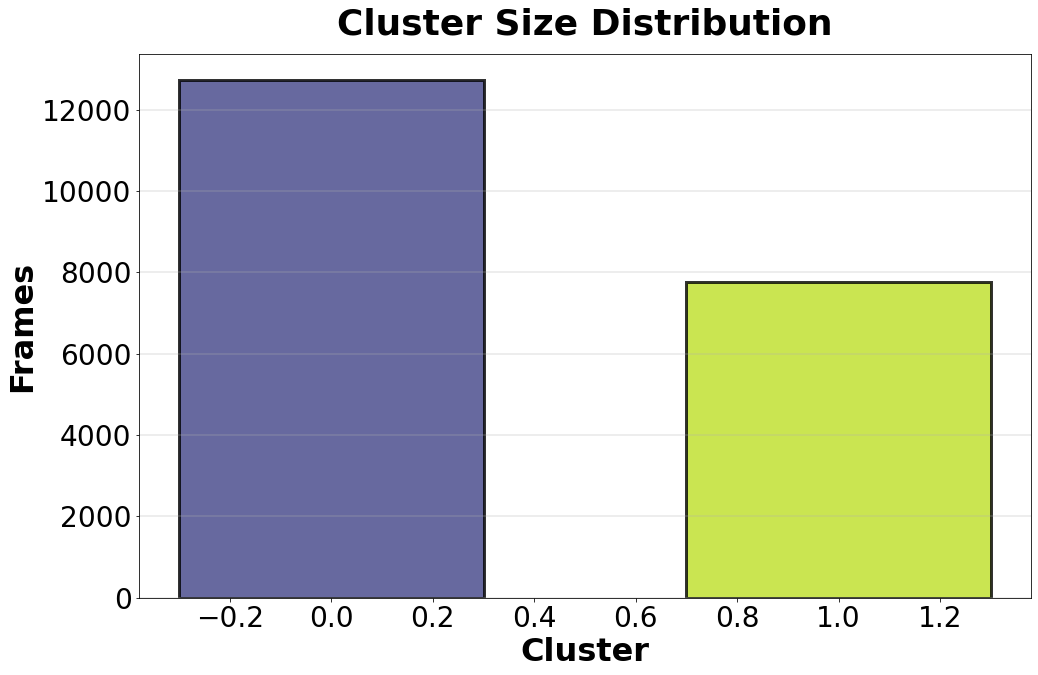


[4/4] Generating results...

ANALYSIS COMPLETE - KEY FINDINGS

Dataset: 40,013 frames analyzed

Movement Profiles:
  • Therapist: 52.0% active (mean speed: 32.1 px/frame)
  • Child: 59.9% active (mean speed: 27.1 px/frame)

Proximity: 218 px average distance (51.4% close)

Responsiveness: 99.1% (771/778 approaches)
   Mean response latency: 0.20s

Movement Coupling: r = 0.055 at 0.3s lag

Pose Clusters:
  • Child: 4 distinct posture patterns (silhouette score: 0.443)
  • Therapist: 2 distinct posture patterns (silhouette score: 0.543)



In [1]:
"""
Enhanced Pose Clustering and Clinical Analysis Pipeline
Combines unsupervised clustering with therapist-child interaction metrics
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import logging
logging.basicConfig(level=logging.ERROR, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)


# =============================================================================
# CONFIGURATION
# =============================================================================

class Config:
    """Central configuration for analysis parameters"""
    
    # Movement detection
    MOVEMENT_THRESHOLD = 10  # pixels/frame for "moving"
    
    # Proximity zones
    PROXIMITY_CLOSE = 200    # pixels
    PROXIMITY_MEDIUM = 400   # pixels
    
    # Response analysis
    RESPONSE_WINDOW = 5      # seconds to check for child response
    
    # Data preprocessing
    CONFIDENCE_THRESHOLD = 0.5
    SMOOTH_WINDOW = 11
    SMOOTH_POLY = 3
    
    # Clustering
    K_RANGE = range(2, 8)
    
    # Session phase analysis
    PHASE_WINDOW = 30  # seconds per window
    N_PHASES = 4
    
    # Role labels (can be overridden)
    THERAPIST_LABEL = "Therapist"
    CHILD_LABEL = "Child"


# =============================================================================
# PART 1: DATA PREPROCESSING
# =============================================================================

class DataPreprocessor:
    """Handles data loading and preprocessing"""
    
    def __init__(self, config=None):
        self.config = config or Config()
        self.df = None
        
    def load_data(self, filepath):
        """Load pose data from CSV"""
        logger.info(f"Loading data from: {filepath}")
        self.df = pd.read_csv(filepath)
        # Rename labels for consistency
        self.df['person_label'] = self.df['person_label'].replace({
            'Patient1': 'Child',
            'Therapist1': 'Therapist'
        })

        # Keep only rows with 'Child' or 'Therapist'
        self.df = self.df[self.df['person_label'].isin(['Child', 'Therapist'])].reset_index(drop=True)

        print(f"Loaded {len(self.df)} rows, {len(self.df.columns)} columns")
        print(f"Participants found: {list(self.df['person_label'].unique())}")
        return self.df
    
    def preprocess(self):
        """Filter, interpolate, and smooth pose data"""
        logger.info("Preprocessing data...")
        
        # Filter by confidence
        initial_len = len(self.df)
        self.df = self.df[self.df['avg_pose_conf'] > self.config.CONFIDENCE_THRESHOLD].copy()
        removed = initial_len - len(self.df)
        logger.info(f'  Filtered {removed} rows ({removed/initial_len*100:.1f}%) with low confidence')
        
        # Interpolate per person
        
        self.df = self.df.groupby('person_label', group_keys=False).apply(
            lambda x: x.drop(columns='person_label')
                      .set_index('time_s')
                      .interpolate(method='linear')
                      .reset_index()
                      .assign(person_label=x['person_label'].iloc[0])
        ).reset_index(drop=True)
        
        
        # Smooth coordinate columns
        coord_cols = [col for col in self.df.columns if col.endswith('_x') or col.endswith('_y')]
        
        for col in coord_cols:
            smooth_col = f"{col}_smooth"
            self.df[smooth_col] = self.df.groupby('person_label')[col].transform(
                lambda x: savgol_filter(x, window_length=self.config.SMOOTH_WINDOW, 
                                       polyorder=self.config.SMOOTH_POLY) 
                          if len(x) >= self.config.SMOOTH_WINDOW else x
            )
        
        logger.info(f"  Smoothed {len(coord_cols)} coordinate columns")
        return self.df
    
    def compute_body_metrics(self):
        """Compute center of mass, velocities, and body part positions"""
        logger.info("Computing body metrics...")
        
        # Get smoothed coordinate columns
        x_cols = [col for col in self.df.columns if col.endswith('_x_smooth')]
        y_cols = [col for col in self.df.columns if col.endswith('_y_smooth')]
        
        if not x_cols:  # Fallback to non-smoothed
            x_cols = [col for col in self.df.columns if col.endswith('_x') and '_smooth' not in col]
            y_cols = [col for col in self.df.columns if col.endswith('_y') and '_smooth' not in col]
        
        # Center of mass
        self.df['com_x'] = self.df[x_cols].mean(axis=1)
        self.df['com_y'] = self.df[y_cols].mean(axis=1)
        
        # Velocities
        self.df['com_x_vel'] = self.df.groupby('person_label')['com_x'].diff() / \
                               self.df.groupby('person_label')['time_s'].diff()
        self.df['com_y_vel'] = self.df.groupby('person_label')['com_y'].diff() / \
                               self.df.groupby('person_label')['time_s'].diff()
        self.df['com_speed'] = np.sqrt(self.df['com_x_vel']**2 + self.df['com_y_vel']**2)
        
        # Head position (nose)
        head_x = 'nose_x_smooth' if 'nose_x_smooth' in self.df.columns else 'nose_x'
        head_y = 'nose_y_smooth' if 'nose_y_smooth' in self.df.columns else 'nose_y'
        self.df['head_x'] = self.df[head_x]
        self.df['head_y'] = self.df[head_y]
        
        # Head velocity
        self.df['head_x_vel'] = self.df.groupby('person_label')['head_x'].diff() / \
                                self.df.groupby('person_label')['time_s'].diff()
        self.df['head_y_vel'] = self.df.groupby('person_label')['head_y'].diff() / \
                                self.df.groupby('person_label')['time_s'].diff()
        self.df['head_speed'] = np.sqrt(self.df['head_x_vel']**2 + self.df['head_y_vel']**2)
        
        # Hand positions (average of both wrists)
        r_wrist_x = 'r_wrist_x_smooth' if 'r_wrist_x_smooth' in self.df.columns else 'r_wrist_x'
        l_wrist_x = 'l_wrist_x_smooth' if 'l_wrist_x_smooth' in self.df.columns else 'l_wrist_x'
        r_wrist_y = 'r_wrist_y_smooth' if 'r_wrist_y_smooth' in self.df.columns else 'r_wrist_y'
        l_wrist_y = 'l_wrist_y_smooth' if 'l_wrist_y_smooth' in self.df.columns else 'l_wrist_y'
        
        self.df['hands_x'] = (self.df[r_wrist_x] + self.df[l_wrist_x]) / 2
        self.df['hands_y'] = (self.df[r_wrist_y] + self.df[l_wrist_y]) / 2
        
        # Hand velocity
        self.df['hands_x_vel'] = self.df.groupby('person_label')['hands_x'].diff() / \
                                 self.df.groupby('person_label')['time_s'].diff()
        self.df['hands_y_vel'] = self.df.groupby('person_label')['hands_y'].diff() / \
                                 self.df.groupby('person_label')['time_s'].diff()
        self.df['hands_speed'] = np.sqrt(self.df['hands_x_vel']**2 + self.df['hands_y_vel']**2)
        
        logger.info("✓ Computed body metrics (COM, velocities, head, hands)")
        return self.df


# =============================================================================
# PART 2: CLINICAL INTERACTION ANALYSIS
# =============================================================================

class ClinicalAnalyzer:
    """Analyzes therapist-child interactions"""
    
    def __init__(self, df, config=None):
        self.df = df
        self.config = config or Config()
        self.movement_profiles = {}
        self.proximity_df = None
        self.approach_events_df = None
        self.lagged_corr_df = None
        self.phases_df = None
        
    def analyze_movement_profiles(self):
        """Analyze movement patterns for therapist and child"""
        logger.info("Analyzing movement profiles...")
        
        for label in [self.config.THERAPIST_LABEL, self.config.CHILD_LABEL]:
            person_data = self.df[self.df['person_label'] == label].copy()
            
            if person_data.empty:
                continue
            
            # Movement detection
            person_data['is_moving'] = person_data['com_speed'] > self.config.MOVEMENT_THRESHOLD
            
            self.movement_profiles[label] = {
                'total_frames': len(person_data),
                'moving_frames': person_data['is_moving'].sum(),
                'activity_ratio': person_data['is_moving'].mean(),
                'mean_speed': person_data['com_speed'].mean(),
                'max_speed': person_data['com_speed'].max(),
                'std_speed': person_data['com_speed'].std(),
                'mean_head_speed': person_data['head_speed'].mean(),
                'mean_hand_speed': person_data['hands_speed'].mean(),
                'spatial_coverage_x': person_data['com_x'].max() - person_data['com_x'].min(),
                'spatial_coverage_y': person_data['com_y'].max() - person_data['com_y'].min(),
            }
        
        logger.info("✓ Movement profiles computed")
        for label, metrics in self.movement_profiles.items():
            logger.info(f"  {label}: {metrics['activity_ratio']*100:.1f}% active, "
                       f"mean speed {metrics['mean_speed']:.1f} px/frame")
        
        return self.movement_profiles
    
    def analyze_proximity(self):
        """Analyze proximity between therapist and child"""
        logger.info("Analyzing proximity dynamics...")
        
        therapist_data = self.df[self.df['person_label'] == self.config.THERAPIST_LABEL][
            ['time_s', 'com_x', 'com_y', 'com_speed']].copy()
        child_data = self.df[self.df['person_label'] == self.config.CHILD_LABEL][
            ['time_s', 'com_x', 'com_y', 'com_speed']].copy()
        
        # Merge on time
        merged = pd.merge(therapist_data, child_data, on='time_s', 
                         suffixes=('_therapist', '_child'))
        
        if merged.empty:
            logger.warning("No overlapping timeframes for proximity analysis")
            return pd.DataFrame()
        
        # Calculate distance
        merged['distance'] = np.sqrt(
            (merged['com_x_therapist'] - merged['com_x_child'])**2 +
            (merged['com_y_therapist'] - merged['com_y_child'])**2
        )
        
        # Proximity zones
        merged['proximity_zone'] = 'far'
        merged.loc[merged['distance'] < self.config.PROXIMITY_MEDIUM, 'proximity_zone'] = 'medium'
        merged.loc[merged['distance'] < self.config.PROXIMITY_CLOSE, 'proximity_zone'] = 'close'
        
        # Distance velocity (approaching/withdrawing)
        merged['distance_vel'] = merged['distance'].diff() / merged['time_s'].diff()
        merged['therapist_approaching'] = merged['distance_vel'] < -5
        merged['therapist_withdrawing'] = merged['distance_vel'] > 5
        
        self.proximity_df = merged
        
        logger.info(f"✓ Proximity analysis complete: mean distance {merged['distance'].mean():.1f} px")
        logger.info(f"  Close: {(merged['proximity_zone']=='close').mean()*100:.1f}%, "
                   f"Medium: {(merged['proximity_zone']=='medium').mean()*100:.1f}%, "
                   f"Far: {(merged['proximity_zone']=='far').mean()*100:.1f}%")
        
        return self.proximity_df
    
    def detect_approach_response(self):
        """Detect therapist approaches and child responses"""
        logger.info("Detecting approach-response events...")
        
        if self.proximity_df is None or self.proximity_df.empty:
            return pd.DataFrame()
        
        # Find approach events
        self.proximity_df['approaching'] = (
            (self.proximity_df['distance_vel'] < -5) & 
            (self.proximity_df['com_speed_therapist'] > self.config.MOVEMENT_THRESHOLD)
        )
        
        # Find transitions to approach
        approach_starts = self.proximity_df[
            self.proximity_df['approaching'] & 
            ~self.proximity_df['approaching'].shift(1).fillna(False)
        ].copy()
        
        events = []
        
        for _, approach in approach_starts.iterrows():
            approach_time = approach['time_s']
            
            # Check child's movement in response window
            child_data = self.df[
                (self.df['person_label'] == self.config.CHILD_LABEL) & 
                (self.df['time_s'] >= approach_time) & 
                (self.df['time_s'] <= approach_time + self.config.RESPONSE_WINDOW)
            ]
            
            if len(child_data) == 0:
                continue
            
            # Did child move?
            child_moved = (child_data['com_speed'] > self.config.MOVEMENT_THRESHOLD).any()
            child_head_moved = (child_data['head_speed'] > self.config.MOVEMENT_THRESHOLD).any()
            child_hands_moved = (child_data['hands_speed'] > self.config.MOVEMENT_THRESHOLD).any()
            
            # Response latency
            moving_frames = child_data[child_data['com_speed'] > self.config.MOVEMENT_THRESHOLD]
            response_latency = None
            if len(moving_frames) > 0:
                response_latency = moving_frames['time_s'].iloc[0] - approach_time
            
            events.append({
                'approach_time': approach_time,
                'initial_distance': approach['distance'],
                'child_responded': child_moved,
                'child_head_response': child_head_moved,
                'child_hand_response': child_hands_moved,
                'response_latency': response_latency,
                'therapist_speed': approach['com_speed_therapist']
            })
        
        self.approach_events_df = pd.DataFrame(events)
        
        if not self.approach_events_df.empty:
            response_rate = self.approach_events_df['child_responded'].mean() * 100
            logger.info(f"✓ Detected {len(self.approach_events_df)} approach events")
            logger.info(f"  Child response rate: {response_rate:.1f}%")
        
        return self.approach_events_df
    
    def compute_lagged_correlation(self, max_lag=10):
        """Compute cross-correlation with time lags"""
        logger.info("Computing lagged correlation...")
        
        therapist_data = self.df[self.df['person_label'] == self.config.THERAPIST_LABEL].sort_values('time_s')
        child_data = self.df[self.df['person_label'] == self.config.CHILD_LABEL].sort_values('time_s')
        
        merged = pd.merge(
            therapist_data[['time_s', 'com_speed']], 
            child_data[['time_s', 'com_speed']], 
            on='time_s', 
            suffixes=('_therapist', '_child')
        )
        
        if merged.empty or len(merged) < 50:
            return pd.DataFrame()
        
        merged = merged.dropna()
        
        correlations = []
        
        for lag in range(-max_lag, max_lag + 1):
            if lag < 0:
                t_speed = merged['com_speed_therapist'].iloc[-lag:].values
                c_speed = merged['com_speed_child'].iloc[:lag].values if lag != 0 else merged['com_speed_child'].values
            elif lag > 0:
                t_speed = merged['com_speed_therapist'].iloc[:-lag].values if lag != 0 else merged['com_speed_therapist'].values
                c_speed = merged['com_speed_child'].iloc[lag:].values
            else:
                t_speed = merged['com_speed_therapist'].values
                c_speed = merged['com_speed_child'].values
            
            if len(t_speed) > 10 and len(c_speed) > 10 and len(t_speed) == len(c_speed):
                if t_speed.std() > 0 and c_speed.std() > 0:
                    corr, _ = pearsonr(t_speed, c_speed)
                    correlations.append({
                        'lag': lag,
                        'lag_seconds': lag * (merged['time_s'].diff().mean() if len(merged) > 1 else 0.033),
                        'correlation': corr
                    })
        
        self.lagged_corr_df = pd.DataFrame(correlations)
        
        if not self.lagged_corr_df.empty:
            max_corr = self.lagged_corr_df.loc[self.lagged_corr_df['correlation'].abs().idxmax()]
            logger.info(f"✓ Max correlation: {max_corr['correlation']:.3f} at lag {max_corr['lag_seconds']:.2f}s")
        
        return self.lagged_corr_df
    
    def detect_session_phases(self):
        """Cluster session into phases based on activity patterns"""
        logger.info("Detecting session phases...")
        
        therapist_data = self.df[self.df['person_label'] == self.config.THERAPIST_LABEL].copy()
        child_data = self.df[self.df['person_label'] == self.config.CHILD_LABEL].copy()
        
        if therapist_data.empty or child_data.empty:
            return pd.DataFrame()
        
        # Create time windows
        time_min = self.df['time_s'].min()
        time_max = self.df['time_s'].max()
        time_bins = np.arange(time_min, time_max, self.config.PHASE_WINDOW)
        
        phases = []
        
        for i in range(len(time_bins) - 1):
            t_start, t_end = time_bins[i], time_bins[i + 1]
            
            t_window = therapist_data[(therapist_data['time_s'] >= t_start) & 
                                     (therapist_data['time_s'] < t_end)]
            c_window = child_data[(child_data['time_s'] >= t_start) & 
                                 (child_data['time_s'] < t_end)]
            
            if len(t_window) == 0 or len(c_window) == 0:
                continue
            
            phases.append({
                'time_start': t_start,
                'time_end': t_end,
                'time_mid': (t_start + t_end) / 2,
                'therapist_activity': (t_window['com_speed'] > self.config.MOVEMENT_THRESHOLD).mean(),
                'child_activity': (c_window['com_speed'] > self.config.MOVEMENT_THRESHOLD).mean(),
                'therapist_mean_speed': t_window['com_speed'].mean(),
                'child_mean_speed': c_window['com_speed'].mean(),
            })
        
        self.phases_df = pd.DataFrame(phases)
        
        if len(self.phases_df) < self.config.N_PHASES:
            return self.phases_df
        
        # Cluster into phases
        features = self.phases_df[['therapist_activity', 'child_activity', 
                                   'therapist_mean_speed', 'child_mean_speed']].values
        
        kmeans = KMeans(n_clusters=self.config.N_PHASES, random_state=42, n_init=10)
        self.phases_df['phase'] = kmeans.fit_predict(features)
        
        logger.info(f"✓ Detected {self.config.N_PHASES} session phases")
        
        return self.phases_df


# =============================================================================
# PART 3: POSE CLUSTERING
# =============================================================================

class PoseClusterer:
    """Perform clustering on pose features"""
    
    def __init__(self, config=None):
        self.config = config or Config()
        self.scaler = StandardScaler()
        self.kmeans = None
        self.optimal_k = None
        self.cluster_results = {}
        
    def extract_features(self, df, person_label):
        """Extract features for clustering"""
        logger.info(f"Extracting features for {person_label}...")
        
        person_df = df[df['person_label'] == person_label].copy()
        
        # Get coordinate columns
        x_cols = [col for col in person_df.columns if '_x_smooth' in col or 
                  (col.endswith('_x') and '_smooth' not in col and col != 'com_x')]
        y_cols = [col for col in person_df.columns if '_y_smooth' in col or 
                  (col.endswith('_y') and '_smooth' not in col and col != 'com_y')]
        
        features = person_df[['time_s'] + x_cols + y_cols].copy()
        
        # Add velocity features
        if 'com_speed' in person_df.columns:
            features['com_speed'] = person_df['com_speed']
            features['com_x_vel'] = person_df['com_x_vel']
            features['com_y_vel'] = person_df['com_y_vel']
        
        # Remove time and handle missing values
        feature_matrix = features.drop(columns=['time_s']).fillna(method='ffill').fillna(method='bfill')
        
        logger.info(f"  Extracted {feature_matrix.shape[1]} features from {len(feature_matrix)} frames")
        
        return feature_matrix, person_df['time_s'].values
    
    def find_optimal_k(self, X):        
        logger.info("Finding optimal number of clusters...")

        X_scaled = self.scaler.fit_transform(X)

        silhouette_scores = []
        inertia_scores = []
        k_values = list(self.config.K_RANGE)

        # Compute metrics for all k values
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            inertia_scores.append(kmeans.inertia_)

            # Silhouette score only valid for k > 1
            if k > 1:
                sil_score = silhouette_score(X_scaled, labels)
                silhouette_scores.append(sil_score)
            else:
                silhouette_scores.append(-1)  # Invalid placeholder

        # === DECISION LOGIC ===

        # 1. Find k with maximum silhouette score (k > 1)
        valid_scores = [(i, score) for i, score in enumerate(silhouette_scores) if score > -1]
        best_sil_idx, best_sil_score = max(valid_scores, key=lambda x: x[1])
        self.optimal_k_sil = k_values[best_sil_idx]

        # 2. Find elbow point using the "kneedle" algorithm or rate of change
        if len(k_values) >= 3:
            # Calculate second derivative (rate of change of rate of change)
            # Normalize inertia scores first
            inertia_norm = np.array(inertia_scores) / max(inertia_scores)
            second_derivative = np.diff(inertia_norm, n=2)

            # Elbow is where second derivative is maximum (steepest change)
            # Skip k=1 for elbow (start from index 0 which represents k=k_values[2])
            elbow_idx = np.argmax(second_derivative) + 2  # +2 because we lost 2 points in diff
            self.optimal_k_elbow = k_values[elbow_idx]
        else:
            self.optimal_k_elbow = k_values[1] if len(k_values) > 1 else k_values[0]

        # 3. Final decision: prefer silhouette, but consider elbow if scores are close
        threshold = 0.05  # Consider scores within 5% as "close"

        if self.optimal_k_sil != self.optimal_k_elbow:
            # Check if elbow point has competitive silhouette score
            elbow_sil_score = silhouette_scores[k_values.index(self.optimal_k_elbow)]

            if best_sil_score - elbow_sil_score <= threshold:
                # Scores are close, prefer the elbow point (often more interpretable)
                self.optimal_k = self.optimal_k_elbow
                logger.info(f"✓ Using elbow k={self.optimal_k} (silhouette: {elbow_sil_score:.3f}, "
                           f"vs best k={self.optimal_k_sil} with {best_sil_score:.3f})")
            else:
                # Silhouette winner is clearly better
                self.optimal_k = self.optimal_k_sil
                logger.info(f"✓ Using silhouette-optimal k={self.optimal_k} (score: {best_sil_score:.3f})")
        else:
            # Both methods agree
            self.optimal_k = self.optimal_k_sil
            logger.info(f"✓ Optimal k={self.optimal_k} (both methods agree, silhouette: {best_sil_score:.3f})")

        # === END DECISION LOGIC ===

        return self.optimal_k, silhouette_scores, inertia_scores, k_values
    
    def fit_predict(self, X, n_clusters=None):
        if n_clusters is None:
            n_clusters = self.optimal_k if self.optimal_k else 3
        
        X_scaled = self.scaler.fit_transform(X)
        
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = self.kmeans.fit_predict(X_scaled)
        
        sil_score = silhouette_score(X_scaled, labels)
        logger.info(f"✓ Clustering complete: {n_clusters} clusters (silhouette: {sil_score:.3f})")
        
        return labels


# =============================================================================
# PART 4: VISUALIZATION
# =============================================================================

class Visualizer:
    """Create comprehensive visualizations"""
    
    @staticmethod
    def plot_clinical_overview(clinical_analyzer, save_path=None):
        """Create comprehensive clinical analysis plot with A0 poster sizing"""
        
        # Define consistent color scheme
        COLOR_SCHEME = {
            'Therapist': '#440154',  # Purple
            'Child': '#31688e',      # Teal
            'Response': '#35b779',   # Green
            'No Response': '#fde725' # Yellow
        }
        
        df = clinical_analyzer.df
        proximity_df = clinical_analyzer.proximity_df
        approach_events_df = clinical_analyzer.approach_events_df
        lagged_corr_df = clinical_analyzer.lagged_corr_df
        phases_df = clinical_analyzer.phases_df
        config = clinical_analyzer.config
        
        # A0 poster sizing - larger fonts
        TITLE_SIZE = 36
        LABEL_SIZE = 32
        TICK_SIZE = 28
        LEGEND_SIZE = 26
        
        output_dir = Path(save_path).parent if save_path else None
        
        # 1. Speed comparison with HEAVY SMOOTHING
        fig1, ax1 = plt.subplots(figsize=(16, 10))
        
        for label in [config.THERAPIST_LABEL, config.CHILD_LABEL]:
            person_data = df[df['person_label'] == label].copy()
            
            # Apply heavy rolling average (window = 50 frames for smooth curve)
            window_size = 50
            person_data['com_speed_smooth'] = person_data['com_speed'].rolling(
                window=window_size, center=True, min_periods=1
            ).mean()
            
            ax1.plot(person_data['time_s'].values, person_data['com_speed_smooth'].values,
                    label=label, alpha=0.9, linewidth=4, color=COLOR_SCHEME[label])
        
        ax1.set_title('Movement Speed (Smoothed)', fontsize=TITLE_SIZE, weight='bold', pad=20)
        ax1.set_xlabel('Time (s)', fontsize=LABEL_SIZE, weight='bold')
        ax1.set_ylabel('Speed (px/frame)', fontsize=LABEL_SIZE, weight='bold')
        ax1.tick_params(axis='both', labelsize=TICK_SIZE)
        ax1.legend(fontsize=LEGEND_SIZE, frameon=True, shadow=True)
        ax1.grid(True, alpha=0.3, linewidth=1.5)
        
        if output_dir:
            fig1.savefig(output_dir / 'movement_speed.png', dpi=300, bbox_inches='tight')
            logger.info(f"✓ Saved: movement_speed.png")
        plt.show()
        plt.close(fig1)
        
        # 2. Proximity
        fig2, ax2 = plt.subplots(figsize=(16, 10))

        if proximity_df is not None and not proximity_df.empty:
            prox_df = proximity_df.dropna(subset=['time_s', 'distance'])
            x = prox_df['time_s'].values
            y = prox_df['distance'].values
            x_new = np.linspace(x.min(), x.max(), num=100)
            f = interp1d(x, y, kind='cubic', fill_value='extrapolate')
            y_interp = f(x_new)
            y_smooth = gaussian_filter1d(y_interp, sigma=3)

            ax2.plot(x_new, y_smooth, linewidth=4, color='#31688e', alpha=0.9, 
                    label='Smoothed Distance')
            ax2.axhline(y=config.PROXIMITY_CLOSE, color='red', linestyle='--', 
                       alpha=0.6, linewidth=3, label='Close Threshold')
            ax2.axhline(y=config.PROXIMITY_MEDIUM, color='orange', linestyle='--', 
                       alpha=0.6, linewidth=3, label='Medium Threshold')

        ax2.set_title('Inter-person Distance', fontsize=TITLE_SIZE, weight='bold', pad=20)
        ax2.set_xlabel('Time (s)', fontsize=LABEL_SIZE, weight='bold')
        ax2.set_ylabel('Distance (pixels)', fontsize=LABEL_SIZE, weight='bold')
        ax2.tick_params(axis='both', labelsize=TICK_SIZE)
        ax2.legend(loc='upper right', fontsize=LEGEND_SIZE, frameon=True, shadow=True)
        ax2.grid(True, alpha=0.3, linewidth=1.5)
        
        if output_dir:
            fig2.savefig(output_dir / 'proximity_distance.png', dpi=300, bbox_inches='tight')
            logger.info(f"✓ Saved: proximity_distance.png")
        plt.show()
        plt.close(fig2)

        # 3. Approach events with THICK BLACK OUTLINES
        fig3, ax3 = plt.subplots(figsize=(16, 10))
        
        if approach_events_df is not None and not approach_events_df.empty:
            responded = approach_events_df[approach_events_df['child_responded']]
            not_responded = approach_events_df[~approach_events_df['child_responded']]
            
            # Response markers
            ax3.scatter(responded['approach_time'].values, responded['initial_distance'].values,
                       color=COLOR_SCHEME['Response'], s=300, alpha=0.8, 
                       label='Response', edgecolor='black', linewidth=3)
            
            # No response markers - THICK BLACK OUTLINE for visibility
            ax3.scatter(not_responded['approach_time'].values, not_responded['initial_distance'].values,
                       color=COLOR_SCHEME['No Response'], s=300, alpha=0.9, 
                       label='No response', edgecolor='black', linewidth=4)
            
            ax3.legend(fontsize=LEGEND_SIZE, frameon=True, shadow=True)
        
        ax3.set_title('Approach Events', fontsize=TITLE_SIZE, weight='bold', pad=20)
        ax3.set_xlabel('Time (s)', fontsize=LABEL_SIZE, weight='bold')
        ax3.set_ylabel('Distance (pixels)', fontsize=LABEL_SIZE, weight='bold')
        ax3.tick_params(axis='both', labelsize=TICK_SIZE)
        ax3.grid(True, alpha=0.3, linewidth=1.5)
        
        if output_dir:
            fig3.savefig(output_dir / 'approach_events.png', dpi=300, bbox_inches='tight')
            logger.info(f"✓ Saved: approach_events.png")
        plt.show()
        plt.close(fig3)
        
        # 4. Session phases
        fig4, ax4 = plt.subplots(figsize=(16, 10))
        
        if phases_df is not None and not phases_df.empty:
            colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(phases_df['phase'].unique())))
            for idx, phase_id in enumerate(phases_df['phase'].unique()):
                phase_data = phases_df[phases_df['phase'] == phase_id]
                ax4.scatter(phase_data['therapist_activity'].values * 100, 
                           phase_data['child_activity'].values * 100,
                           s=400, alpha=0.7, label=f'Phase {phase_id + 1}', 
                           color=colors[idx], edgecolor='black', linewidth=3)
            ax4.legend(fontsize=LEGEND_SIZE, frameon=True, shadow=True)
        
        ax4.set_title('Session Phases', fontsize=TITLE_SIZE, weight='bold', pad=20)
        ax4.set_xlabel('Therapist Activity (%)', fontsize=LABEL_SIZE, weight='bold')
        ax4.set_ylabel('Child Activity (%)', fontsize=LABEL_SIZE, weight='bold')
        ax4.tick_params(axis='both', labelsize=TICK_SIZE)
        ax4.grid(True, alpha=0.3, linewidth=1.5)
        
        if output_dir:
            fig4.savefig(output_dir / 'session_phases.png', dpi=300, bbox_inches='tight')
            logger.info(f"✓ Saved: session_phases.png")
        plt.show()
        plt.close(fig4)
    
    @staticmethod
    def plot_clustering_results(features, labels, times, person_label,
                                optimal_k, silhouette_scores, inertia_scores, k_values, save_path=None):
        """Visualize clustering results with A0 poster sizing and individual plot saves"""
        
        # A0 poster sizing
        TITLE_SIZE = 36
        LABEL_SIZE = 32
        TICK_SIZE = 28
        LEGEND_SIZE = 26
        
        output_dir = Path(save_path).parent if save_path else None
        
        # Scale features for PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(features)

        # 1. Silhouette scores
        fig1, ax1 = plt.subplots(figsize=(16, 10))
        ax1.plot(k_values, silhouette_scores, 'o-', linewidth=4, markersize=15, 
                color='#440154', markeredgecolor='black', markeredgewidth=2)
        ax1.axvline(x=optimal_k, color='red', linestyle='--', linewidth=4, 
                   label=f'Optimal k={optimal_k}', alpha=0.7)
        ax1.set_xlabel('Number of Clusters (k)', fontsize=LABEL_SIZE, weight='bold')
        ax1.set_ylabel('Silhouette Score', fontsize=LABEL_SIZE, weight='bold')
        ax1.set_title('Silhouette Method', fontsize=TITLE_SIZE, weight='bold', pad=20)
        ax1.tick_params(axis='both', labelsize=TICK_SIZE)
        ax1.legend(fontsize=LEGEND_SIZE, frameon=True, shadow=True)
        ax1.grid(True, alpha=0.3, linewidth=1.5)
        
        if output_dir:
            fig1.savefig(output_dir / f'silhouette_{person_label}.png', dpi=300, bbox_inches='tight')
            logger.info(f"✓ Saved: silhouette_{person_label}.png")
        plt.show()
        plt.close(fig1)

        # 2. Elbow method (NO optimal k line)
        fig2, ax2 = plt.subplots(figsize=(16, 10))
        ax2.plot(k_values, inertia_scores, 'o-', linewidth=4, markersize=15, 
                color='#31688e', markeredgecolor='black', markeredgewidth=2)
        ax2.set_xlabel('Number of Clusters (k)', fontsize=LABEL_SIZE, weight='bold')
        ax2.set_ylabel('Inertia (WCSS)', fontsize=LABEL_SIZE, weight='bold')
        ax2.set_title('Elbow Method', fontsize=TITLE_SIZE, weight='bold', pad=20)
        ax2.tick_params(axis='both', labelsize=TICK_SIZE)
        ax2.grid(True, alpha=0.3, linewidth=1.5)
        
        if output_dir:
            fig2.savefig(output_dir / f'elbow_{person_label}.png', dpi=300, bbox_inches='tight')
            logger.info(f"✓ Saved: elbow_{person_label}.png")
        plt.show()
        plt.close(fig2)

        # 3. PCA projection
        fig3, ax3 = plt.subplots(figsize=(16, 10))
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', 
                              alpha=0.7, s=150, edgecolor='black', linewidth=2)
        ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', 
                      fontsize=LABEL_SIZE, weight='bold')
        ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', 
                      fontsize=LABEL_SIZE, weight='bold')
        ax3.set_title(f'PCA Projection - {person_label}', fontsize=TITLE_SIZE, weight='bold', pad=20)
        ax3.tick_params(axis='both', labelsize=TICK_SIZE)
        cbar = plt.colorbar(scatter, ax=ax3)
        cbar.set_label('Cluster', fontsize=LABEL_SIZE, weight='bold')
        cbar.ax.tick_params(labelsize=TICK_SIZE)
        
        if output_dir:
            fig3.savefig(output_dir / f'pca_{person_label}.png', dpi=300, bbox_inches='tight')
            logger.info(f"✓ Saved: pca_{person_label}.png")
        plt.show()
        plt.close(fig3)

        # 4. Cluster size distribution
        fig4, ax4 = plt.subplots(figsize=(16, 10))
        unique, counts = np.unique(labels, return_counts=True)
        colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(unique)))
        ax4.bar(unique, counts, color=colors, edgecolor='black', alpha=0.8, linewidth=3, width=0.6)
        ax4.set_xlabel('Cluster', fontsize=LABEL_SIZE, weight='bold')
        ax4.set_ylabel('Frames', fontsize=LABEL_SIZE, weight='bold')
        ax4.set_title('Cluster Size Distribution', fontsize=TITLE_SIZE, weight='bold', pad=20)
        ax4.tick_params(axis='both', labelsize=TICK_SIZE)
        ax4.grid(True, alpha=0.3, axis='y', linewidth=1.5)
        
        if output_dir:
            fig4.savefig(output_dir / f'cluster_distribution_{person_label}.png', dpi=300, bbox_inches='tight')
            logger.info(f"✓ Saved: cluster_distribution_{person_label}.png")
        plt.show()
        plt.close(fig4)


# =============================================================================
# MAIN PIPELINE
# =============================================================================

def run_pose_clustering(data_path, output_dir=None, config=None):
    """
    Complete integrated pipeline for pose clustering and clinical analysis
    
    Args:
        data_path: Path to project directory or processed_data.csv
        output_dir: Directory to save outputs
        config: Configuration object (optional)
    
    Returns:
        Dictionary with all results
    """
    
    print("\n" + "="*70)
    print("INTEGRATED POSE CLUSTERING & CLINICAL ANALYSIS PIPELINE")
    print("="*70)
    
    # Initialize configuration
    config = config or Config()
    
    # Determine file path
    data_path = Path(data_path)
    if data_path.is_dir():
        csv_path = data_path / "processed_data.csv"
    else:
        csv_path = data_path
    
    if not csv_path.exists():
        raise FileNotFoundError(f"Data file not found: {csv_path}")
    
    # Setup output directory
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(exist_ok=True, parents=True)
    
    # STEP 1: Load and preprocess data
    print("\n[1/4] Loading and preprocessing data...")
    preprocessor = DataPreprocessor(config)
    df = preprocessor.load_data(csv_path)
    df = preprocessor.preprocess()
    df = preprocessor.compute_body_metrics()
    
    # STEP 2: Clinical analysis
    print("\n[2/4] Analyzing clinical interactions...")
    clinical = ClinicalAnalyzer(df, config)
    clinical.analyze_movement_profiles()
    clinical.analyze_proximity()
    clinical.detect_approach_response()
    clinical.compute_lagged_correlation()
    clinical.detect_session_phases()
    
    # Visualize clinical results
    clinical_plot_path = output_dir / 'clinical_analysis.png' 
    save_path=str(clinical_plot_path)
    Visualizer.plot_clinical_overview(clinical, save_path=save_path)

    
    # STEP 3: Pose clustering (per person)
    print("\n[3/4] Clustering pose patterns...")
    clusterer = PoseClusterer(config)
    cluster_results = {}
    
    available_persons = df['person_label'].unique()
    print(f"  Found persons: {', '.join(available_persons)}")
    
    for person_label in available_persons:
        print(f"  → Analyzing {person_label}...")
        
        # Extract features
        try:
            features, times = clusterer.extract_features(df, person_label)
            
            if len(features) < 10:
                print(f"     Warning: Not enough data for {person_label} (only {len(features)} frames)")
                continue
            
            # Find optimal k
            optimal_k, sil_scores, inertia_scores, k_values = clusterer.find_optimal_k(features.values)
            
            # Perform clustering
            labels = clusterer.fit_predict(features.values, n_clusters=optimal_k)
            
            # Store results
            cluster_results[person_label] = {
                'features': features,
                'labels': labels,
                'times': times,
                'optimal_k': optimal_k,
                'silhouette_scores': sil_scores,
                'k_values': k_values
            }
            
            # Visualize
            cluster_plot_path = output_dir / f'clustering_{person_label}.png' if output_dir else None
            Visualizer.plot_clustering_results(
                features.values, labels, times, person_label,
                optimal_k, sil_scores, inertia_scores, k_values,
                save_path=cluster_plot_path
            )
        except Exception as e:
            print(f"     Error processing {person_label}: {str(e)}")
            continue

    
    # STEP 4: Generate combined results DataFrame
    print("\n[4/4] Generating results...")
    results_dfs = []
    
    for person_label, result in cluster_results.items():
        person_results = pd.DataFrame({
            'time_s': result['times'],
            'person_label': person_label,
            'cluster': result['labels'],
            'optimal_k': result['optimal_k']
        })
        results_dfs.append(person_results)
    
    combined_results = pd.concat(results_dfs, ignore_index=True)
    
    # Merge with original data
    final_results = df.merge(combined_results, on=['time_s', 'person_label'], how='left')
    
    if output_dir:
        results_path = output_dir / 'pose_clusters_with_clinical.csv'
        final_results.to_csv(results_path, index=False)
        logger.info(f"✓ Results saved: {results_path}")
    
    # STEP 5: Summary report
    print("\n" + "="*70)
    print("ANALYSIS COMPLETE - KEY FINDINGS")
    print("="*70)
    
    print(f"\nDataset: {len(df):,} frames analyzed")
    
    print("\nMovement Profiles:")
    for label, metrics in clinical.movement_profiles.items():
        print(f"  • {label}: {metrics['activity_ratio']*100:.1f}% active "
              f"(mean speed: {metrics['mean_speed']:.1f} px/frame)")
    
    if clinical.proximity_df is not None and not clinical.proximity_df.empty:
        mean_dist = clinical.proximity_df['distance'].mean()
        close_pct = (clinical.proximity_df['proximity_zone'] == 'close').mean() * 100
        print(f"\nProximity: {mean_dist:.0f} px average distance ({close_pct:.1f}% close)")
    
    if clinical.approach_events_df is not None and not clinical.approach_events_df.empty:
        response_rate = clinical.approach_events_df['child_responded'].mean() * 100
        n_events = len(clinical.approach_events_df)
        responded = clinical.approach_events_df['child_responded'].sum()
        print(f"\nResponsiveness: {response_rate:.1f}% ({responded}/{n_events} approaches)")
        
        # Add latency information
        latencies = clinical.approach_events_df[clinical.approach_events_df['child_responded']]['response_latency'].dropna()
        if len(latencies) > 0:
            print(f"   Mean response latency: {latencies.mean():.2f}s")
    
    if clinical.lagged_corr_df is not None and not clinical.lagged_corr_df.empty:
        max_corr = clinical.lagged_corr_df.loc[clinical.lagged_corr_df['correlation'].abs().idxmax()]
        print(f"\nMovement Coupling: r = {max_corr['correlation']:.3f} at {max_corr['lag_seconds']:.1f}s lag")
    
    print("\nPose Clusters:")
    for person_label, result in cluster_results.items():
        sil_score = max(result['silhouette_scores'])
        print(f"  • {person_label}: {result['optimal_k']} distinct posture patterns "
              f"(silhouette score: {sil_score:.3f})")
    
    print("\n" + "="*70)
    
    return {
        'data': final_results,
        'clinical_analyzer': clinical,
        'cluster_results': cluster_results,
        'config': config
    }


# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":
    # Example: Specify your data path and output directory
    results = run_pose_clustering(
        data_path="/home/liubov/Bureau/new/processed_data/11-1-2024_#9_INDIVIDUAL_[18]",
        output_dir="/home/liubov/Bureau/new/output_data/11-1-2024_#9_INDIVIDUAL_[18]"
    )
    pass